In [1]:
from noisepicker import find_Noise_Windows
from obspy.core.utcdatetime import UTCDateTime
import time
import pickle
import random
import numpy as np

# function to return project filepaths
def project_Filepaths(project_Name: str, start_Time: UTCDateTime, end_Time: UTCDateTime):
    """Returns list of strings of filepaths for specified project, assuming
    files span a single day and start at T00.00.00.

    Parameters:
        project_Name: list
            list of strings that represent mseed filepaths

    Example:
        filepaths = project_Filepaths("Rattlesnake Ridge")
    """
    if project_Name == "Rattlesnake Ridge":
        # build filepath list based on dates
        node = ['DP1'] #, 'DP2', 'DPZ']  # nodal seismometer channels
        ugap = ['EHN'] #, 'EHE', 'EHZ']
        stations_channels = {'1': node, '2': node, '3': node, '4': node,
                             '5': node, '6': node, '7': node, '8': node,
                             '9': node, '10': node, '12': node, '13': node,
                             '15': node, '16': node, '17': node, '18': node,
                             '20': node, '21': node, '22': node, '23': node,
                             '25': node, '26': node, '27': node, '28': node,
                             '30': node, '31': node, '32': node, '33': node,
                             '34': node, '35': node, '36': node, '37': node,
                             '38': node, '39': node, '40': node, '41': node,
                             '42': node, 'UGAP3': ugap, 'UGAP5': ugap,
                             'UGAP6': ugap}

        # assemble filepaths
        filepaths = []
        for station in stations_channels:
            for channel in stations_channels[station]:
                filepath = f"/Users/human/Desktop/RR_MSEED/5A.{station}.." \
                           f"{channel}.{start_Time.year}-" \
                           f"{start_Time.month:02}-{start_Time.day:02}T00.00.00.ms"
                # save filepath to list
                filepaths.append(filepath)

    return filepaths

In [2]:
"""
##########################
### FIND NOISE WINDOWS ###
##########################

# FIXME: also supports filtering, add to description. 

Use the find_Noise_Windows function to identify windows of a 
specified length (in samples) with STA/LTA (of the specified 
STA window length and LTA window length in samples) less than
the specified threshold value. This function can be used to 
find noise windows in a single time window or many time 
windows, as shown below. The code below demonstrates how to 
pass multiple time periods to find_Noise_Windows. To find the
noise windows that occur in a single time period, pass the
start and end times as a list of a tuple containing the start
and end times, like the following:

# define the start and end times
start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
end_Time =   UTCDateTime("2018-03-13T11:59:59.9999999Z")

# find_Noise_Windows expects a list of tuples
time_Period = [(start_Time, end_Time)]

# define filepaths and detection_Parameters
project_Name = "Rattlesnake Ridge"
filepaths = project_Filepaths(project_Name, start_Time, end_Time)
detection_Parameters = (15, 250, 5, 240)  

# pass the relevant parameters to find_Noise_Windows after they
# have been defined
noise_Windows, noise_Windows_Times = find_Noise_Windows(filepaths,
    detection_Parameters, time_Periods)
    
This function also supports bandpass filtering from 20-60 Hz and 
linear detrending by setting the "filter" parameter to True, and 
instrument response correction by setting the "response" parameter 
to true. Both are false by default. The instrument response file 
should be located in an acessible folder and specified in the 
find_Noise_Windows function.
"""
# multiple or single time period(s)?
multiple = False

# time the run
start = time.time()

# define variables needed to find noise windows

# one or more time periods can be passed to find_Noise_Windows.
# passing multiple time windows is demonstrated here

# this could be done in a brute force manner like the commented
# code below:
'''
start_Time_1 = UTCDateTime("2018-03-13T00:00:00.0Z")
end_Time_1 =   UTCDateTime("2018-03-13T00:04:59.9999999Z")

start_Time_2 = UTCDateTime("2018-03-13T02:00:00.0Z")
end_Time_2 =   UTCDateTime("2018-03-13T02:04:59.9999999Z")

start_Time_3 = UTCDateTime("2018-03-13T04:00:00.0Z")
end_Time_3 =   UTCDateTime("2018-03-13T04:04:59.9999999Z")

time_Periods = [(start_Time_1, end_Time_1),
                (start_Time_2, end_Time_2),
                (start_Time_3, end_Time_3)]
'''
# for multiple time periods
if multiple:
    # or we can specify programatically that we want 10 second
    # time periods starting at midnight, with their start times
    # offset by one hour, for an entire calendar day
    time_Period_Length = 10 # seconds
    time_Period_Offset = 1 # hours
    time_Period_Start = UTCDateTime("2018-03-13T00:00:00.0Z")
    time_Periods = []

    # loop through time periods and append to list
    for index in range(int(24 / time_Period_Offset)):
        # convert time_Period_Offset to seconds
        time_Period_Offset_Seconds = time_Period_Offset * 60 * 60
        start_Time = time_Period_Start + (index * time_Period_Offset_Seconds)
        end_Time = start_Time + time_Period_Length
        time_Period = (start_Time, end_Time)
        time_Periods.append(time_Period)

    # fetch the filepaths for this project, filepaths are the same
    # for all time periods contained within a calendar day 
    project_Name = "Rattlesnake Ridge"
    filepaths = project_Filepaths(project_Name, time_Periods[0][0], time_Periods[0][1])
    
# for a single time period    
else:
    # define the start and end times
    start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")

    # find_Noise_Windows expects a list of tuples
    time_Periods = [(start_Time, end_Time)]

    # define filepaths and detection_Parameters
    project_Name = "Rattlesnake Ridge"
    filepaths = project_Filepaths(project_Name, start_Time, end_Time)
    
# store the STA window length in samples, the LTA window length in
# samples, the threshold value, and the noise window length in samples
detection_Parameters = (15, 250, 3, 240)

# pass the relevant variables to noisepicker.find_Noise_Windows
noise_Windows, noise_Windows_Times = find_Noise_Windows(filepaths, 
                            detection_Parameters, time_Periods, 
                            filter=True, response=True)

# check the run time and number of found noise windows
end = time.time()
run_Details = (end-start, len(noise_Windows))

# save run details to a pickle
outfile = open('run_details.pkl', 'wb')
pickle.dump(run_Details, outfile)
outfile.close()

# print run details
print(f"Runtime: {(end - start)} seconds.")
print(f"         {(end - start) / 60} minutes.")
print(f"         {(end - start) / 60 / 60} hours.")
print(f"Found {len(noise_Windows)} noise windows.")

 Processing station: 1, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 69467 noise windows.
station/channel runtime: 2.30 minutes.
 Processing station: 2, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 59174 noise windows.
station/channel runtime: 2.22 minutes.
 Processing station: 3, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 70113 noise windows.
station/channel runtime: 2.19 minutes.
 Processing station: 4, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 58428 noise windows.
station/channel runtime: 2.22 minutes.
 Processing station: 5, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 64697 noise windows.
station/channel runtime: 2.20 minutes.
 Processing station: 6, channel: DP1
2018-03-13T00:00:00.000000Z----2018-03-14T00:00:00.000000Z      Found 47457 noise windows.
station/channel runtime: 2.22 minutes

In [2]:
"""
From here down each cell is optional and exists for a specific purpose.
Use the cells that apply to your purpose. 

######################
# LOAD NOISE WINDOWS #
######################

Perhaps your kernel died or you had to shut down your computer
in preparation to evacuate from a wildfire (2020 has no chill).
The function find_Noise_Windows and the previous cell save the
results to pickle files. To load files point inspect to True. 

This cell is also utilized as a run log during exploratory
analysis where details from past calls to find_Noise_Windows 
are documented.

"""
# inspect the results
inspect = True

if inspect:
    # run log:
    # 00 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 2, 240)
    #         filter=False
    # 01 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 5, 240)
    #         filter=False
    # 02 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 4, 240)
    #         filter=False
    # 03 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 3, 240)
    #         filter=False
    # 04 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 1, 240)
    #         filter=False
    # 05 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 0.1, 240)
    #         filter=False
    # 06 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 0.5, 240)
    #         filter=False
    # 07 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 10, 240)
    #         filter=False
    # 08 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 3, 240)
    #         filter=True <------
    # 09 is fixed windows for 1 day
    #         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
    #         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
    #         detection_Parameters = (15, 250, 3, 240)
    #         filter=True <------
    #         response=True <----
    
    run_num = "03"
    # load run details for program runtime and number of noise windows
    infile = open(f'{run_num}_run_details.pkl','rb')
    run_Details = pickle.load(infile)
    infile.close()
    print(f"Runtime: {run_Details[0] / 60 / 60} hours.")
    print(f"Found {run_Details[1]} noise windows.")
    
    # load noise windows from pickle file
    infile = open(f'{run_num}_noise_windows.pkl', 'rb')
    noise_Windows = pickle.load(infile)
    infile.close()
    
    # load info associated with noise windows (times, station, channel)
    infile = open(f'{run_num}_noise_times.pkl', 'rb')
    noise_Windows_Times = pickle.load(infile)
    infile.close()


Runtime: 1.475656234489547 hours.
Found 2155922 noise windows.


In [ ]:
"""
###############################
# AUTO-VALIDATE NOISE WINDOWS #
###############################

Use the verify_Noise_Windows function to remove false-positive
"noise" windows that contain first arrival picks. This means
you should pick all first arrivals for the time period in which
you are searching for noise windows. This function imports P-wave
first arrival picks from a snuffler marker file and discards
noise windows that contain picks. If you do not have picks for
all time periods for which you want to extract noise windows, 
see the cells below which accomidate visual validation of noise
windows.

"""
# import the relevant function
from noisepicker import verify_Noise_Windows

# load noise windows from pickle file
infile = open('noise_windows.pkl', 'rb')
noise_Windows = pickle.load(infile)
infile.close()

# load info associated with noise windows (times, station, channel)
infile = open('noise_times.pkl', 'rb')
noise_Windows_Times = pickle.load(infile)
infile.close()

# define the path to the snuffler marker file
marker_File_Path = 'picks.mrkr'

# verify p-wave picks and return noise windows (and their info)
verified_Noise_Windows, verified_Noise_Times = verify_Noise_Windows(noise_Windows, 
                                            noise_Windows_Times, marker_File_Path)

In [8]:
"""
####################################
### TAKE SUBSET OF NOISE WINDOWS ###
####################################

Suppose you are feeding these noise windows to an ANN for automated
phase picking. In that case you probably want to take a subset of the
noise windows. This cell accomplishes that. 

"""
# define the number of noise windows desired
subset_Size = 10000

# do you want to save the subset to a pickle? 
save = True

# randomly select subset indices
random_List = random.sample(range(0, len(noise_Windows)), subset_Size)

# extract those indices
noise_Windows = np.take(noise_Windows, random_List, axis=0)
noise_Windows_Times = np.take(noise_Windows_Times, random_List, axis=0)

# maybe save the subset 
if save:
    outfile = open('noise_windows_for_validation.pkl', 'wb')
    pickle.dump(noise_Windows, outfile)
    outfile.close()
    outfile = open('noise_windows_times_for_validation.pkl', 'wb')
    pickle.dump(noise_Windows_Times, outfile)
    outfile.close()

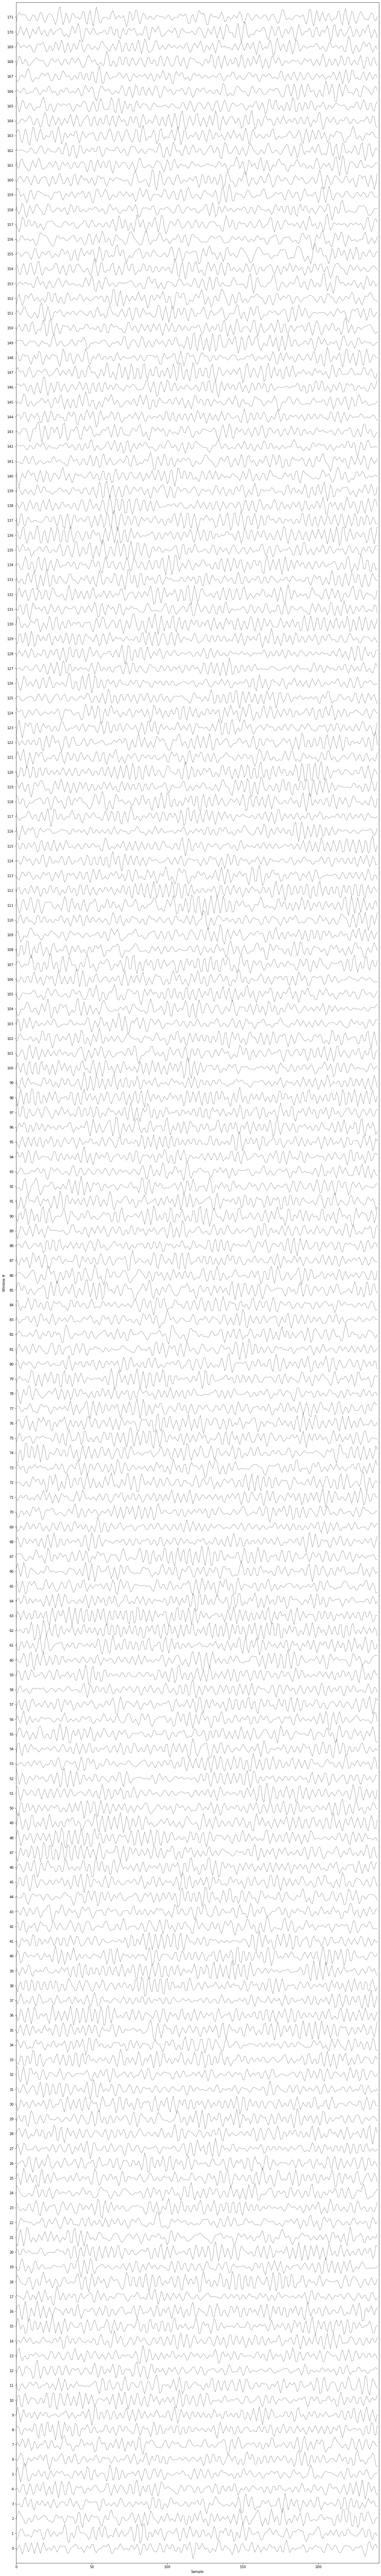

In [4]:
"""
###############################
### PLOT SOME NOISE WINDOWS ###
###############################

Plot normalized noise windows, optionally with timestamps. Plot
without timestamps is more compact. This function breaks when 
plotting > 172 noise windows, so use slicing to identify subset.

"""
# import the relevant function
from noisepicker import plot_Noise_Windows

# specify whether or not you want to plot noise windows with timestamps
PLOT_WITH_TIMES = False

if PLOT_WITH_TIMES:
    # plot noise windows with their associated times (less compact so plot fewer windows)
    plot_Noise_Windows(noise_Windows[:20], noise_Windows_Times[:20])

else:
    # plot noise windows utilizing slicing
    plot_Noise_Windows(noise_Windows[600:772]) # breaks when plotting > 172 lines
    
# # or you can plot and label the y-axis with an array of integers, like below,
# # otherwise the y-axis is labeled 0 to len(noise_Windows), or 0-172, whichever 
# # range is less
# plot_Noise_Windows(noise_Windows[600:772], indices=list(range(800, 972)))

Noise windows before validation: 12000


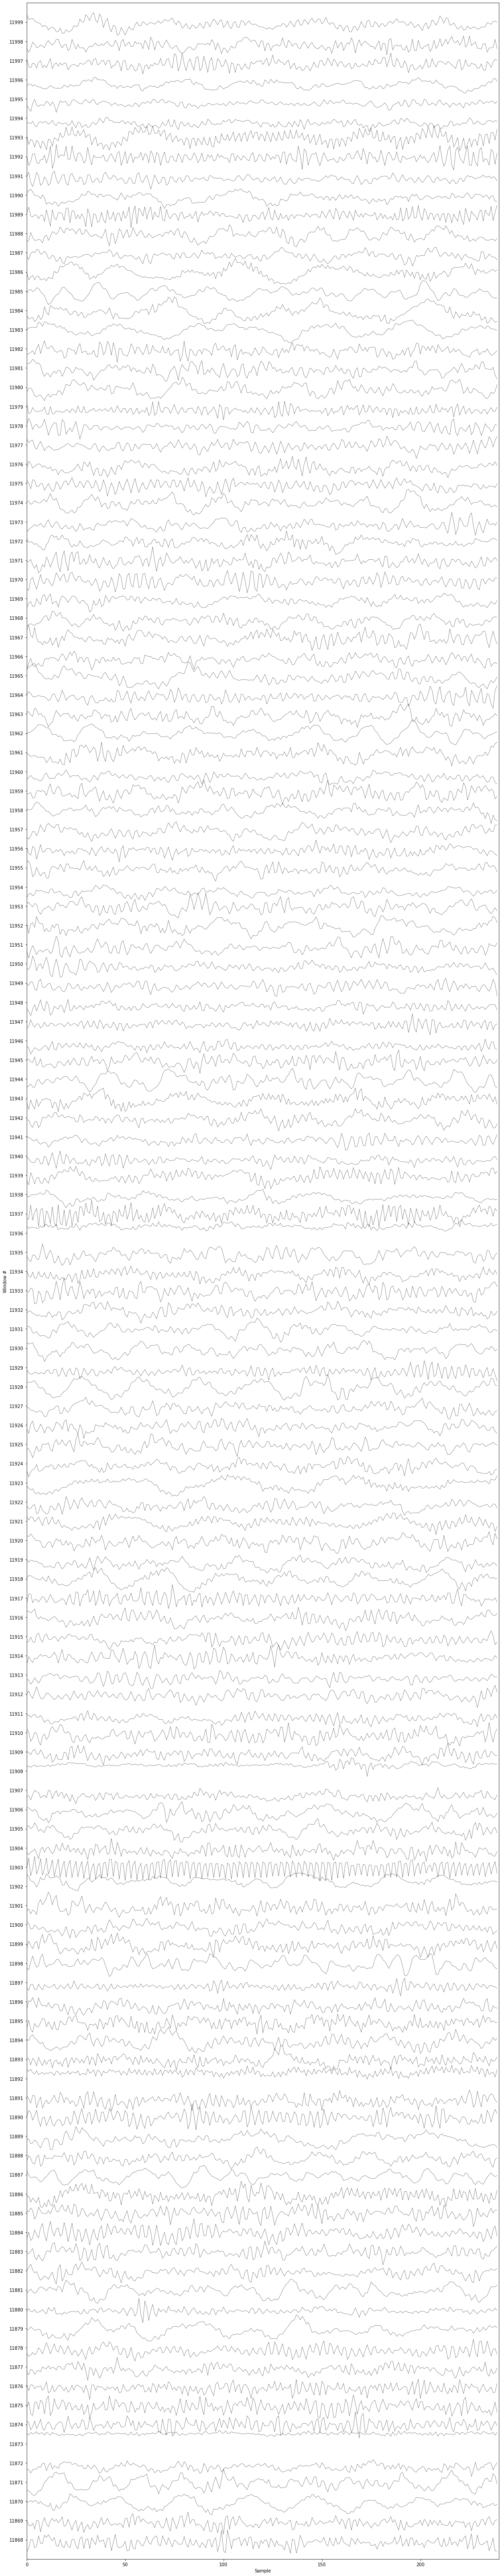

Enter 'quit', nothing, or space separated indices of noise windows to be flagged for removal:  11880 11906 11908


Noise windows after validation: 11839


In [9]:
"""
##############################
### PLOT ALL NOISE WINDOWS ###
### FOR  VISUAL VALIDATION ###
### &  EXCLUDE BAD WINDOWS ###
##############################

Plot normalized noise windows, 172 at a time, using the 
explore_Noise_Windows function to visually validate noise windows.
This function will ask for user input after plotting the first
set of noise windows. Specify noise window indices to remove from
the set (as space delimited integers). "quit" may be input to exit
plotting. If no input is specified (simply hit return key) then the
function skips to plotting the next batch of noise windows. One the
end of the noise windows is reached, the function will return a copy
of noise_Windows and noise_Windows_Times that has the specified indices
removed. If quit before the end of the noise windows is reached, None 
is returned. To allow processing noise windows in multiple sessions, 
once "quit" is specified a pickle file titled priors_Pickle.pkl will 
be written to the current working directory. The pickle file contains 
the index of first noise window in the figure when you specified 
"quit", in addition to all removal indices specified during the session. 
To start where you left off, specify the pickle file while calling 
explore_Noise_Windows like below:

validated_Noise_Windows, validated_Noise_Windows_Times = explore_Noise_Windows(noise_Windows, noise_Windows_Times, priors_Pickle="priors_Pickle.pkl")

# but to start you can simply use the syntax below: 
validated_Noise_Windows, validated_Noise_Windows_Times = explore_Noise_Windows(noise_Windows, noise_Windows_Times)

The rest of this cell imports two pickle files containing
a saved copy of noise_Windows and noise_Windows_Times (as output from
the various functions above), then calls the function 
explore_Noise_Windows to visually validate the noise windows, then saves 
the results of the visual noise validatation as two new pickle files
that contain the noise windows and noise windows times with the 
specified indices removed. This cell will only save the validated noise
windows and times upon completion of visual validation of all noise
windows contained in that set. That means this cell can be run as many
times as necessary to finish validating the noise windows since results
are saved upon specifying "quit" as user input.
"""
# import the relevant function
from noisepicker import explore_Noise_Windows

# load noise windows from pickle file
infile = open(f'noise_windows_for_validation.pkl', 'rb')
noise_Windows = pickle.load(infile)
infile.close()
# and noise windows times
infile = open(f'noise_windows_times_for_validation.pkl', 'rb')
noise_Windows_Times = pickle.load(infile)
infile.close()

print(f"Noise windows before validation: {len(noise_Windows)}")

# call explore_Noise_Windows to begin visual validation of noise windows
validated_Noise_Windows, validated_Noise_Windows_Times = explore_Noise_Windows(noise_Windows, noise_Windows_Times, priors_Pickle="priors_Pickle.pkl")

# only save the validated results after completing validation
# of all noise windows, otherwise validated_Noise_Windows == None
if type(validated_Noise_Windows) == np.ndarray:
    run_num = "03"
    print(f"Noise windows after validation: {len(validated_Noise_Windows)}")
    # then save the returned noise windows once you reach the end of the batch
    outfile = open(f'{run_num}_validated_noise_windows.pkl', 'wb')
    pickle.dump(validated_Noise_Windows, outfile)
    outfile.close()
    outfile = open(f'{run_num}_validated_noise_windows_times.pkl', 'wb')
    pickle.dump(validated_Noise_Windows_Times, outfile)
    outfile.close()
    
# run log:
# 03 is 12000 random noise windows from 1 day (subset of 03 in above runlog)
#         start_Time = UTCDateTime("2018-03-13T00:00:00.0Z")
#         end_Time =   UTCDateTime("2018-03-13T23:59:59.9999999Z")
#         detection_Parameters = (15, 250, 3, 240)
#         noise windows after validaion = 11839

Finding the counts per bin is slow...
1 of 24
2 of 24
3 of 24
4 of 24
5 of 24
6 of 24
7 of 24
8 of 24
9 of 24
10 of 24
11 of 24
12 of 24
13 of 24
14 of 24
15 of 24
16 of 24
17 of 24
18 of 24
19 of 24
20 of 24
21 of 24
22 of 24
23 of 24
24 of 24


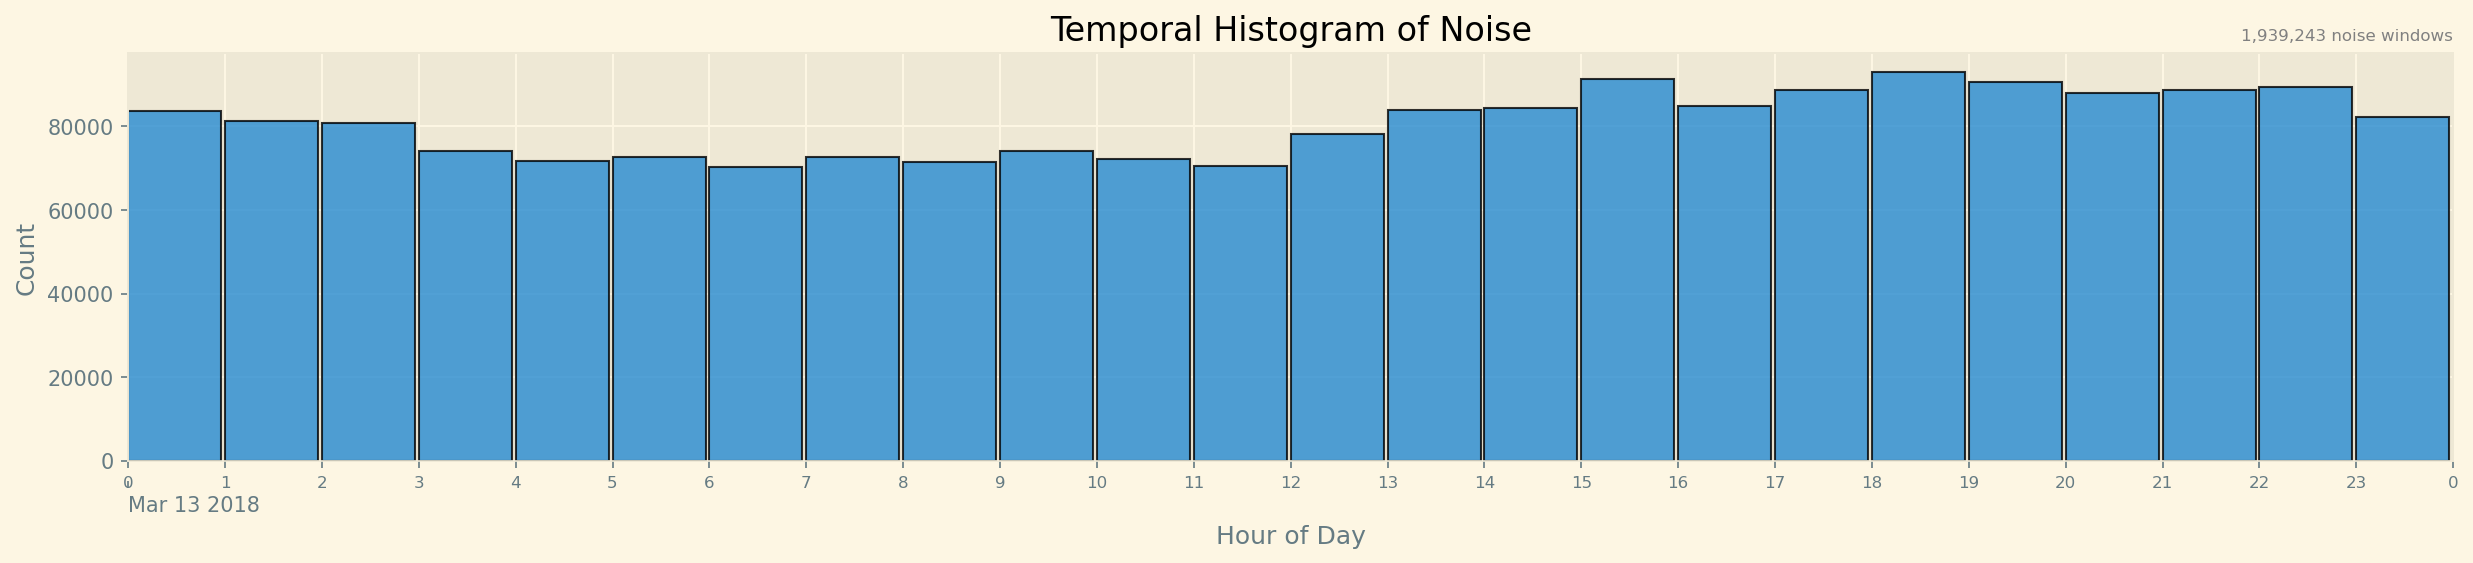

In [5]:
"""
#################################
# PLOT NOISE WINDOWS HISTOGRAMS #
#################################

Plot histograms of noise windows to visualize their
temporal and spatial distributions.

"""
# import the relevant functions
from noisepicker import plot_Noise_Time_Histogram, plot_Noise_Station_Histogram

# specify bin size for time histogram
bin_Width = 60 * 60 # 60 minutes

# pass the relevant data to plot_Noise_Time_Histogram
# by default this function will set the major x tick to hours and minor 
# x tick to minutes, appropriate for plotting an entire calendar day.
# Other major and minor ticks can be specified if desired. 
plot_Noise_Time_Histogram(noise_Windows_Times, bin_Width)

Finding the counts per bin is slow...
1 of 40
2 of 40
3 of 40
4 of 40
5 of 40
6 of 40
7 of 40
8 of 40
9 of 40
10 of 40
11 of 40
12 of 40
13 of 40
14 of 40
15 of 40
16 of 40
17 of 40
18 of 40
19 of 40
20 of 40
21 of 40
22 of 40
23 of 40
24 of 40
25 of 40
26 of 40
27 of 40
28 of 40
29 of 40
30 of 40
31 of 40
32 of 40
33 of 40
34 of 40
35 of 40
36 of 40
37 of 40
38 of 40
39 of 40
40 of 40


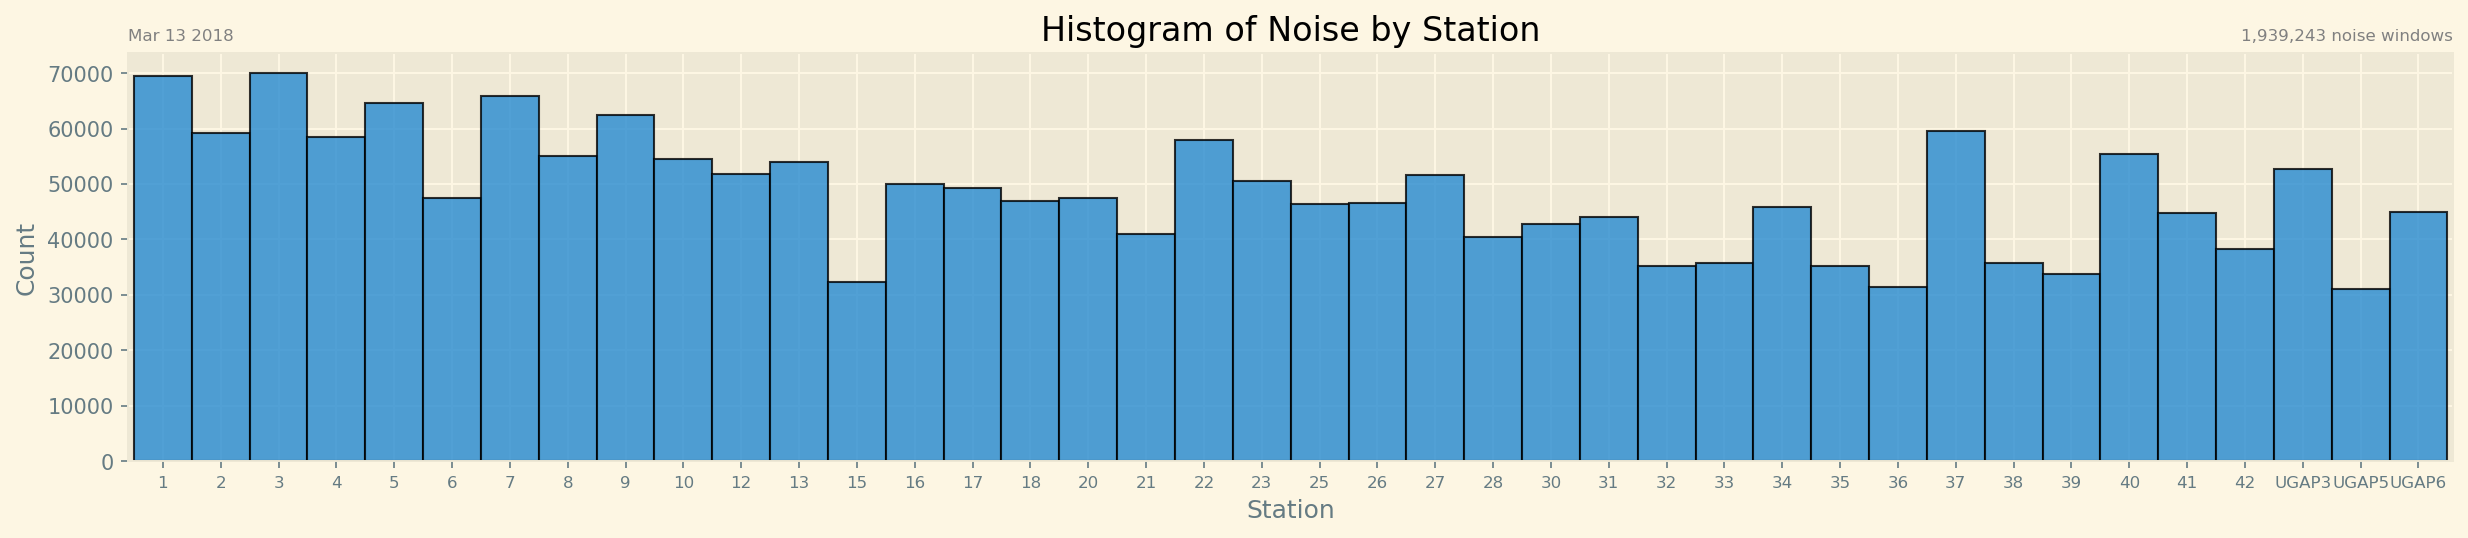

In [6]:
# next plot the noise station histogram
stations = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
            '12', '13', '15', '16', '17', '18', '20', '21', '22', 
            '23', '25', '26', '27', '28', '30', '31', '32', '33', 
            '34', '35', '36', '37', '38', '39', '40', '41', '42', 
            'UGAP3', 'UGAP5', 'UGAP6']

# pass stations and times to function
plot_Noise_Station_Histogram(noise_Windows_Times, stations)

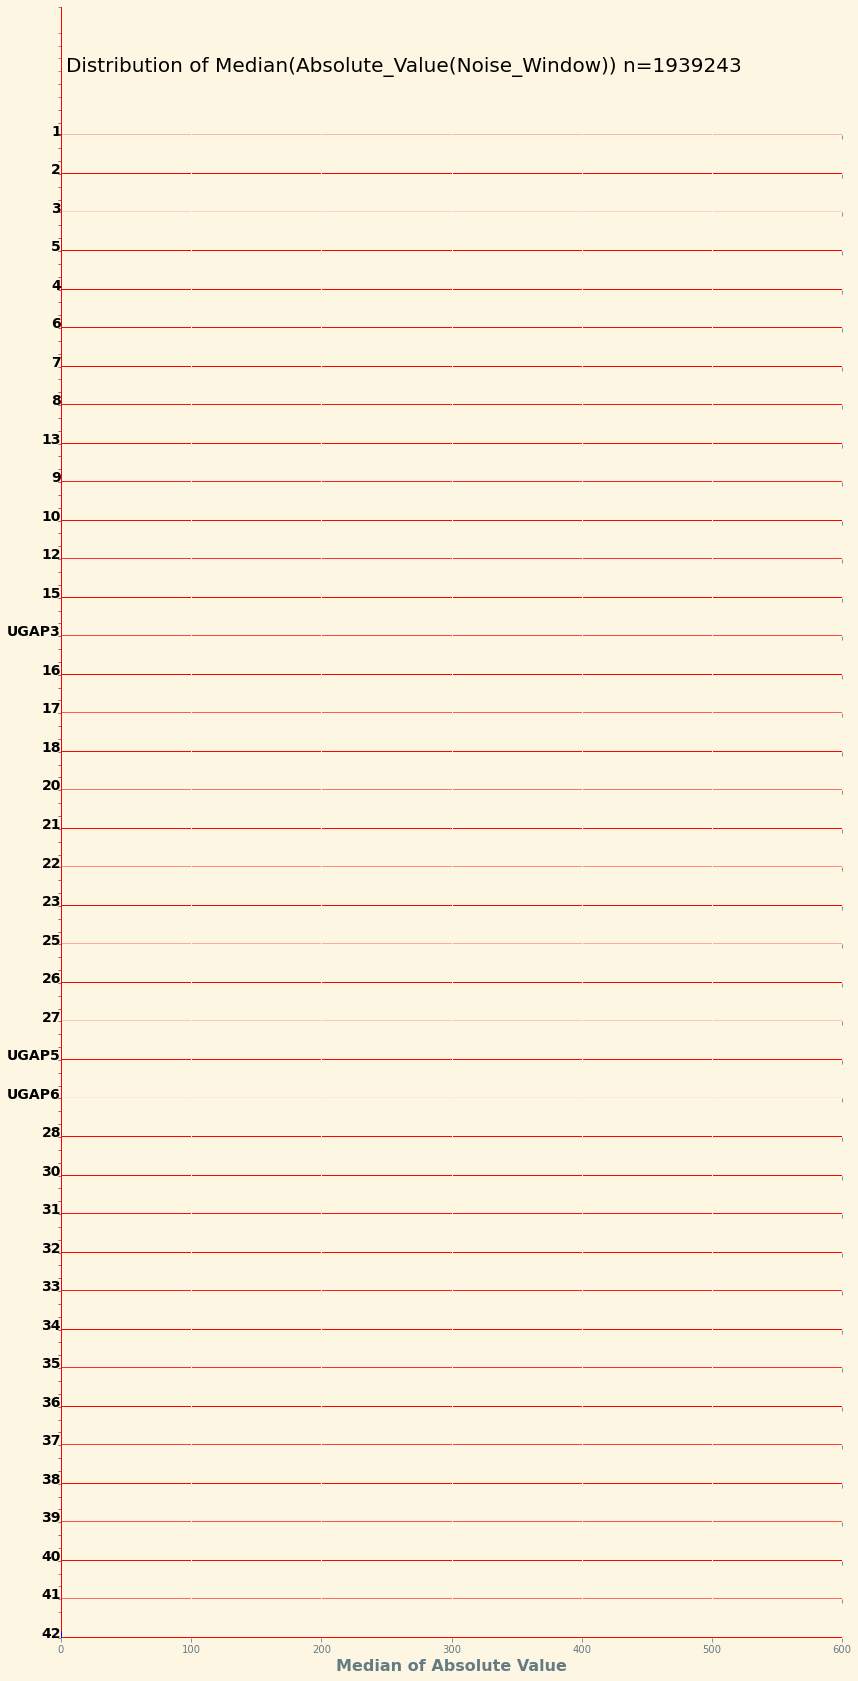

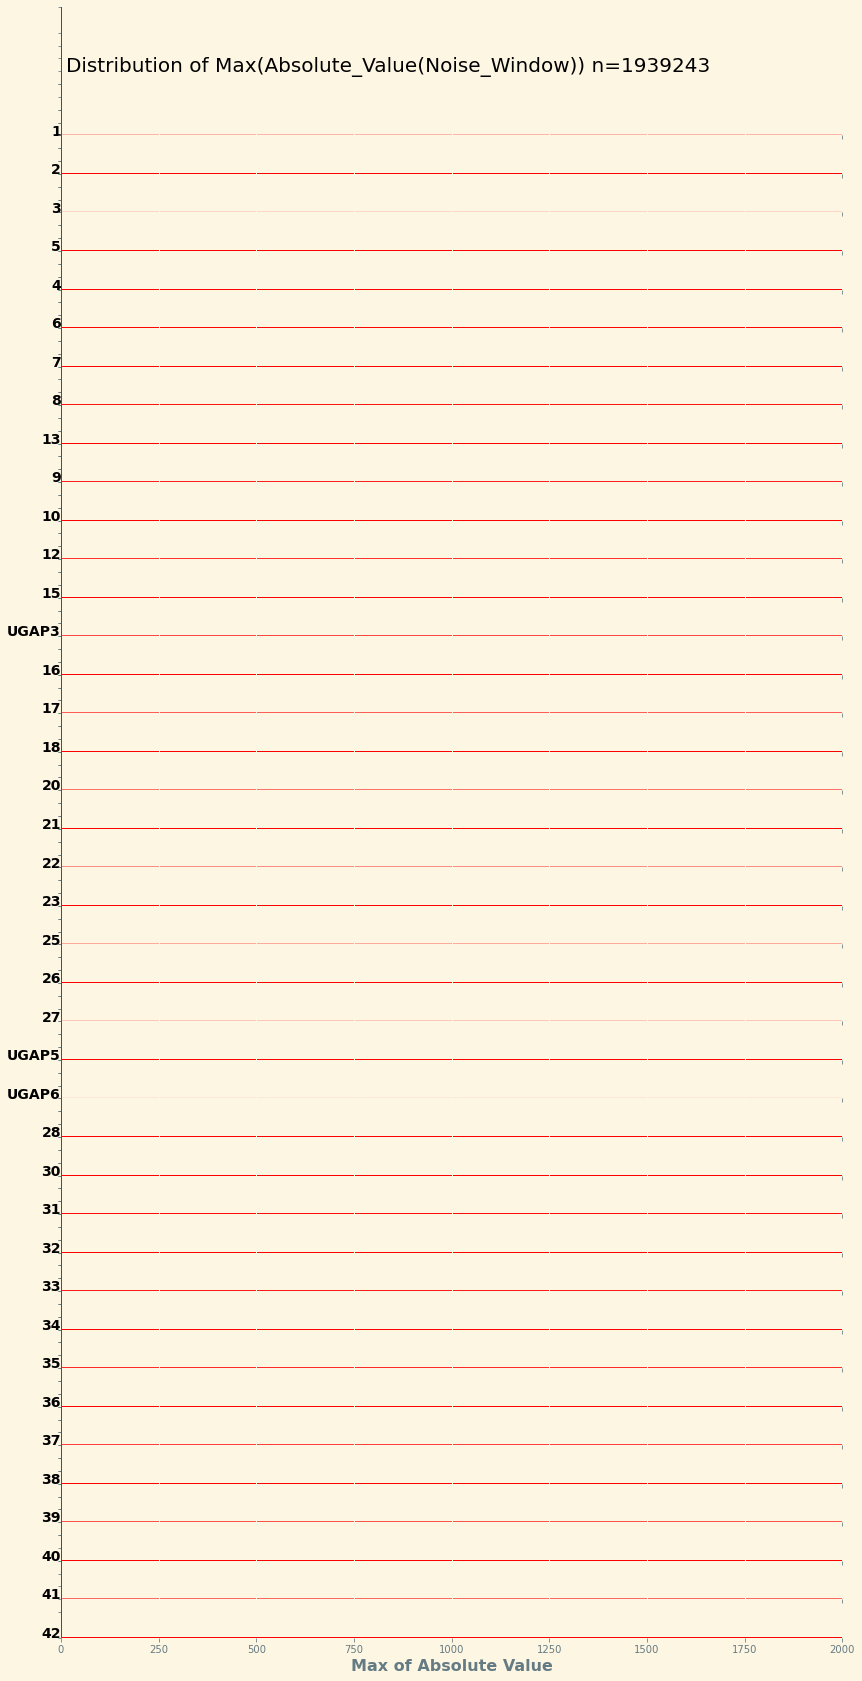

In [7]:
"""
#########################
# ANALYZE NOISE WINDOWS #
#########################

Function plots distributions of noise windows metrics for each station 
and saves a file "noise_metrics.csv" containing rows of each station name, 
the mean of the absolute value of all noise windows, and the median of the
absolute value of all noise windows. 

"""
# import the relevant functions
from noisepicker import analyze_Noise_Windows

metric_Map = analyze_Noise_Windows(noise_Windows, noise_Windows_Times)

In [6]:
# load noise windows from pickle file
infile = open('03_validated_noise_windows.pkl', 'rb')
noise = pickle.load(infile)
infile.close()

print(type(noise))
print(len(noise))
print(noise)

FileNotFoundError: [Errno 2] No such file or directory: '03_validated_noise_windows.pkl'

In [ ]:
outfile = open(f'{run_num}_validated_noise_windows.pkl', 'wb')
    pickle.dump(validated_Noise_Windows, outfile)
    outfile.close()